В данной задаче нам представлены данные в которых ключевое поле — это то, просрочит ли клиент микро-финансовой организации выплату более чем на 60 дней или нет. 
Нам нужно построить модель, которая по входным данным предсказывала бы с максимальной точностью ключе-вой параметр. 
Основной параметр это delinq60plus. Остальные парамет-ры интуитивно понятны из таблиц.

## Цель

Построить модель машинного обучения для предсказания вероятности того, что клиент уйдет в просрочку более 60 дней.

## Задача
осуществить корректную загрузку данных
осуществить разведывательный анализ данных:
- разбить выборку на обучающую и тестовую
- проанализировать пропуски и решить, что с ними делать
- проанализировать выбросы
- создать/ удалить переменные
- закодировать категориальные переменные
- нормализовать числовые переменные (при необходимости)

построить модель и оценить ее качество
при необходимости вернуться к предыдущим шагам, чтобы улучшить качество модели


## Высокая цель. Использовать (не везде, а где мы работаем с данными напрямую) SQL запросы. 

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import sqlite3
import statistics 

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

df = pd.read_csv("UTF_MFOcredit.csv", delimiter = ';')

In [2]:
df.head()

,id,date_start,date_end,gender,age,auto,housing,marstatus,regclient,jobtype,region,credits,children,delinq60plus
0,1,03-Jan-2013,12-Jan-2013,Мужской,44,Нет,Собственное,Гражданский брак/женат/замужем,Нет,Официальное,Новосибирская область,Нет,Да,Нет
1,2,03-Jan-2013,17-Jan-2013,Мужской,21,Пропуск поля,Живут с родителями,Холост,Нет,Официальное,Кемеровская область юг,Да,Нет,Нет
2,3,03-Jan-2013,17-Jan-2013,Мужской,25,Пропуск поля,Собственное,Холост,Да,Официальное,Кемеровская область север,Пропуск поля,Нет,Нет
3,4,03-Jan-2013,17-Jan-2013,Женский,47,Пропуск поля,Собственное,Гражданский брак/женат/замужем,Да,Официальное,Кемеровская область север,Нет,Нет,Нет
4,5,03-Jan-2013,17-Jan-2013,Мужской,22,Нет,Арендуемое,Гражданский брак/женат/замужем,Нет,Официальное,Кемеровская область север,Да,Да,Нет


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35212 entries, 0 to 35211
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            35212 non-null  int64 
 1   date_start    35212 non-null  object
 2   date_end      35212 non-null  object
 3   gender        35212 non-null  object
 4   age           35212 non-null  int64 
 5   auto          35212 non-null  object
 6   housing       35212 non-null  object
 7   marstatus     35212 non-null  object
 8   regclient     35212 non-null  object
 9   jobtype       35212 non-null  object
 10  region        35212 non-null  object
 11  credits       35212 non-null  object
 12  children      35212 non-null  object
 13  delinq60plus  35212 non-null  object
dtypes: int64(2), object(12)
memory usage: 3.8+ MB


Судя по cтатистике, явных пропусков по данному датасету нет, однако, как можно видеть уже и из первых 4 строк датасета, среди данных присутствует такое значение как "Пропуск поля". Найдем процентное соотношщение таких данных по каждому столбцу

In [4]:
for col in df.columns:
    pct_missing = np.mean(df[col] == "Пропуск поля")
    print('{} - {}%'.format(col, round(pct_missing*100)))

id - 0%
date_start - 0%
date_end - 0%
gender - 0%
age - 0%
auto - 40%
housing - 22%
marstatus - 21%
regclient - 0%
jobtype - 41%
region - 0%
credits - 3%
children - 2%
delinq60plus - 0%


Таким образом, исходя из гипотезы, что пропуск поля считается пропуском данных, имеем следующие столбцы с пропусками: auto, housing, marstatus, jobtype, credits, children. Обработывать пропуски по данным столбцам будем уже после разбивки датасета на тренировочную и тестовую выборки. Однако перед разбитием необходимо в датасет внести некоторые корректировки, а именно:
1. Удалить поле id, поскольку оно не несет в себе никакой информации
2. Преобразовать датф в столбцах date_start и date_end
3. Сразу закодируем значение столбцов delinq60plus, поскольку мы его принимаем за y, которое необходимо предсказать

In [5]:
#Поскольку столбец client_id является обозначением номера клиента и не несет в себе никакой больше информации, удаляем его
data_set = df.drop(df.columns[[0]], axis = 1)
data_set.head()

,date_start,date_end,gender,age,auto,housing,marstatus,regclient,jobtype,region,credits,children,delinq60plus
0,03-Jan-2013,12-Jan-2013,Мужской,44,Нет,Собственное,Гражданский брак/женат/замужем,Нет,Официальное,Новосибирская область,Нет,Да,Нет
1,03-Jan-2013,17-Jan-2013,Мужской,21,Пропуск поля,Живут с родителями,Холост,Нет,Официальное,Кемеровская область юг,Да,Нет,Нет
2,03-Jan-2013,17-Jan-2013,Мужской,25,Пропуск поля,Собственное,Холост,Да,Официальное,Кемеровская область север,Пропуск поля,Нет,Нет
3,03-Jan-2013,17-Jan-2013,Женский,47,Пропуск поля,Собственное,Гражданский брак/женат/замужем,Да,Официальное,Кемеровская область север,Нет,Нет,Нет
4,03-Jan-2013,17-Jan-2013,Мужской,22,Нет,Арендуемое,Гражданский брак/женат/замужем,Нет,Официальное,Кемеровская область север,Да,Да,Нет


In [6]:
#кодируем значение delinq60plus: "Да" соответствует 1, "Нет" - 0
data_set.loc[(data_set["delinq60plus"] == "Нет"), "delinq60plus"] = 0
data_set.loc[(data_set["delinq60plus"] == "Да"), "delinq60plus"]= 1

data_set["delinq60plus"] = pd.to_numeric(data_set ["delinq60plus"])

## Приведем даты к стандартному значению

In [7]:
start_date = data_set["date_start"].tolist()
end_date = data_set["date_end"].tolist()

month = {'01': 'Jan', '02': 'Feb', '03':'Mar', '04':'Apr', '05':'May', '06':'Jun',
         '07':'Jul', '08':'Aug', '09':'Sep', '10':'Oct', '11':'Nov', '12':'Dec'}

def transforming_date(word):
    for k, v in month.items():
        if v == word[1]:
            word[1] = k
    transformed_word = '.'.join(word)
    transformed_date = datetime.strptime(transformed_word, '%d.%m.%Y').date()
    return transformed_date

start_counter = 0

for _ in start_date:
    word = start_date[start_counter].split('-')
    start_date[start_counter] = transforming_date(word)
    start_counter +=1
    
end_counter = 0

for _ in end_date:
    word = end_date[end_counter].split('-')
    end_date[end_counter] = transforming_date(word)
    end_counter +=1
    
    
    
col_days = []  

for i in range(len(start_date)):
    diff = str(end_date[i] - start_date[i])
    word = diff.split()
    day = int(word[0])
    col_days.append(day)

#внесем преобразованные даты
data_set.insert(loc = 0 , column = 'start_date', value = start_date)
data_set.insert(loc = 1 , column = 'end_date', value = end_date)
data_set = data_set.drop(columns = ['date_start', 'date_end'], axis = 1)

#приведем даты к типу datetime
data_set['start_date'] = pd.to_datetime(data_set ['start_date']).dt.normalize()
data_set['end_date'] = pd.to_datetime(data_set['end_date']).dt.normalize()

#проеобразуем floatдля возможности в будущем корректно обучить модель
data_set[('start_date')] = data_set[('start_date')].values.astype("float64")
data_set[('end_date')] = data_set[('end_date')].values.astype("float64")

In [8]:
data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35212 entries, 0 to 35211
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   start_date    35212 non-null  float64
 1   end_date      35212 non-null  float64
 2   gender        35212 non-null  object 
 3   age           35212 non-null  int64  
 4   auto          35212 non-null  object 
 5   housing       35212 non-null  object 
 6   marstatus     35212 non-null  object 
 7   regclient     35212 non-null  object 
 8   jobtype       35212 non-null  object 
 9   region        35212 non-null  object 
 10  credits       35212 non-null  object 
 11  children      35212 non-null  object 
 12  delinq60plus  35212 non-null  int64  
dtypes: float64(2), int64(2), object(9)
memory usage: 3.5+ MB


Таким образом после предобразования корректные типы данных по date_start и date_end.

## Разобьем датасет на тренировочную и тестовую выборки

In [9]:
train, test = train_test_split(data_set, test_size=0.3, random_state = 1)

#обновим индексы выборок
train.set_index(np.arange(len(train)), inplace=True)
test.set_index(np.arange(len(test)), inplace=True)

Занесем тестовую и тренирововчную выборку в БД

In [10]:
con = sqlite3.connect('db')

train.to_sql('train_db',con,index=False,if_exists='replace')
test.to_sql('test_db',con,index=False,if_exists='replace')

def select(sql):
  return pd.read_sql(sql,con)

С помощью SQL найдем уникальные значения для каждого поля, в котором есть пропуски в тестовой и тренировочной выборках.

Категориальные значения по столбцу  auto:

In [11]:
train_sql = ''' SELECT DISTINCT auto FROM train_db'''
print(select(train_sql))

test_sql = ''' SELECT DISTINCT auto FROM test_db'''
print(select(test_sql))

           auto
0  Пропуск поля
1           Нет
2            Да
           auto
0  Пропуск поля
1           Нет
2            Да


В обоих случаях видим, что значения столбца auto может принимать значения "ДА", "НЕТ" или "ПРОПУСК ПОЛЯ". Значения пропуск поля считаем пропуском и будем заменять на самое встречаемое в зависимости от региона проживания и пола данного чеовека

In [12]:
#выведем таблицу для мужского пола
cur = con.cursor()
sql = '''drop table if exists M_AUTO_NO;
create table M_AUTO_NO as
SELECT count(*) AS NO, region FROM train_db AS t
where auto =="Нет" AND gender = "Мужской" GROUP by region;

drop table if exists M_AUTO_YES;
create table M_AUTO_YES as
SELECT count(*) AS YES, region FROM train_db AS t
where auto =="Да" AND gender = "Мужской" GROUP by region;
'''

cur.executescript(sql)

sql = '''select M_AUTO_YES.region, M_AUTO_YES.YES, M_AUTO_NO.NO
from M_AUTO_YES
LEFT outer JOIN M_AUTO_NO
where M_AUTO_YES.region = M_AUTO_NO.region'''


select(sql)

#исходя из выборки видим, средин мужчин вне зависимости от региона преобюлают те, кто не имеет машины

,region,YES,NO
0,Алтайский край,378,1185
1,Кемеровская область север,566,1380
2,Кемеровская область юг,468,1495
3,Красноярский край,205,403
4,Новосибирская область,228,850


In [13]:
#выведем таблицу для женского пола
cur = con.cursor()
sql = '''drop table if exists F_AUTO_NO;
create table F_AUTO_NO as
SELECT count(*) AS NO, region FROM train_db AS t
where auto =="Нет" AND gender = "Женский" GROUP by region;

drop table if exists F_AUTO_YES;
create table F_AUTO_YES as
SELECT count(*) AS YES, region FROM train_db AS t
where auto =="Да" AND gender = "Женский" GROUP by region;
'''

cur.executescript(sql)

sql = '''select F_AUTO_YES.region, F_AUTO_YES.YES, F_AUTO_NO.NO
from F_AUTO_YES
LEFT outer JOIN F_AUTO_NO
where F_AUTO_YES.region = F_AUTO_NO.region'''

select(sql)

#исходя из выборки видим, средин женщин вне зависимости от региона преобюлают те, кто не имеет машины

,region,YES,NO
0,Алтайский край,148,1683
1,Кемеровская область север,150,1883
2,Кемеровская область юг,110,1549
3,Красноярский край,163,705
4,Новосибирская область,119,1104


Исходя из выборок видич, что по областям меньше женщин по каждому региону владеет машинами, чем мужчина, но при этом в каджом регионе большинство людей вне зависимости от пола не имеют своей машину, поэто пропуски зщаполним значением "Нет"

In [14]:
cleaned_train = train.copy(deep = True)
cleaned_train.loc[(cleaned_train["auto"] == "Пропуск поля"), "auto"] = "Нет"

Провежем аналогичный анализ с помощью SQL запросов для тестовой выборки

In [15]:
#выведем таблицу для мужского пола
sql = '''drop table if exists M_AUTO_NO;
create table M_AUTO_NO as
SELECT count(*) AS NO, region FROM test_db AS t
where auto =="Нет" AND gender = "Мужской" GROUP by region;

drop table if exists M_AUTO_YES;
create table M_AUTO_YES as
SELECT count(*) AS YES, region FROM test_db AS t
where auto =="Да" AND gender = "Мужской" GROUP by region;
'''

cur.executescript(sql)

sql = '''select M_AUTO_YES.region, M_AUTO_YES.YES, M_AUTO_NO.NO 
from M_AUTO_YES
LEFT outer JOIN M_AUTO_NO
where M_AUTO_YES.region = M_AUTO_NO.region'''


select(sql)

#исходя из выборки видим, средин мужчин вне зависимости от региона преобюлают те, кто не имеет машины

,region,YES,NO
0,Алтайский край,161,507
1,Кемеровская область север,247,577
2,Кемеровская область юг,225,588
3,Красноярский край,97,187
4,Новосибирская область,109,411


In [16]:
#выведем таблицу для женского пола
sql = '''drop table if exists F_AUTO_NO;
create table F_AUTO_NO as
SELECT count(*) AS NO, region FROM test_db AS t
where auto =="Нет" AND gender = "Женский" GROUP by region;

drop table if exists F_AUTO_YES;
create table F_AUTO_YES as
SELECT count(*) AS YES, region FROM test_db AS t
where auto =="Да" AND gender = "Женский" GROUP by region;
'''

cur.executescript(sql)

sql = '''select F_AUTO_NO.region, F_AUTO_NO.NO, F_AUTO_YES.YES from F_AUTO_YES
LEFT outer JOIN F_AUTO_NO
where F_AUTO_YES.region = F_AUTO_NO.region'''

select(sql)

#исходя из выборки видим, средин женщин вне зависимости от региона преобюлают те, кто не имеет машины

,region,NO,YES
0,Алтайский край,720,58
1,Кемеровская область север,829,68
2,Кемеровская область юг,627,51
3,Красноярский край,311,69
4,Новосибирская область,471,50


Исходя из выборок видич, что по областям меньше женщин по каждому региону владеет машинами, чем мужчина, но при этом в каджом регионе большинство людей вне зависимости от пола не имеют своей машину, поэто пропуски зщаполним значением "Нет"

In [17]:
cleaned_test = test.copy(deep = True)
cleaned_test.loc[(cleaned_test["auto"] == "Пропуск поля"), "auto"] = "Нет"

С помощью SQL найдем уникальные значения для каждого поля, в котором есть пропуски в тестовой и тренировочной выборках.

Категориальные значения по столбцу  housing:

In [18]:
train_sql = ''' SELECT DISTINCT housing AS TRAIN_HOUSING FROM train_db'''
print(select(train_sql))

test_sql = ''' SELECT DISTINCT housing AS TEST_HOUSING FROM test_db'''
print(select(test_sql))

           TRAIN_HOUSING
0            Собственное
1           Пропуск поля
2  Долевая собственность
3     Живут с родителями
4             Арендуемое
5          Муниципальное
            TEST_HOUSING
0     Живут с родителями
1          Муниципальное
2            Собственное
3           Пропуск поля
4  Долевая собственность
5             Арендуемое


Значение"Пропуск поля" будем считать пропуском данных, который должен быть обработан. Заполнение пропусков будет проводить наиболее часто встречающимя категориальным значением с учетом возраста клиента. Для этого разобьем клиентов по нескольким группам: до 20, с 20 до 45 и после 45

In [19]:
sql = ''' drop table if exists house_before_20;
create table house_before_20 as
select housing, count(*) AS count_before_20 from train_db
where age < 20 AND housing != "Пропуск поля"
group by housing;

drop table if exists house_after_20;
create table house_after_20 as
select housing, count(*) AS count_after_20 from train_db
where age > 20 AND age < 45 AND housing != "Пропуск поля"
group by housing;

drop table if exists house_after_45;
create table house_after_45 as
select housing, count(*) as count_after_45 from train_db
where age > 45 AND housing != "Пропуск поля"
group by housing;
'''
cur.executescript(sql)

sql = '''select house_before_20.housing, house_before_20.count_before_20, 
house_after_20.count_after_20, house_after_45.count_after_45
from house_before_20
LEFT outer JOIN house_after_20 ON house_before_20.housing = house_after_20.housing
LEFT outer JOIN house_after_45 ON house_before_20.housing = house_after_45.housing'''

select(sql)

,housing,count_before_20,count_after_20,count_after_45
0,Арендуемое,33,1184,130
1,Долевая собственность,21,1657,341
2,Живут с родителями,107,1891,69
3,Муниципальное,7,526,389
4,Собственное,75,7797,4468


In [20]:
#исходя их выборки, видим, что большинство клиентов до 20 живут с родитедями, а после 20 - в собственной квартире, в связи 
#с этим заполнять пропуски бужем с учетом возраста: если до 20 заполняем значением "Живут с родителями", после - "Собственное"

counter = 0

for row_house in cleaned_train["housing"]:
    if row_house == "Пропуск поля":
        buff = cleaned_train.iloc[counter]
        if buff["age"] < 20:
            cleaned_train.loc[counter, "housing"] = "Живут с родителями"
        else:
            cleaned_train.loc[counter, "housing"] = "Собственное"
    counter +=1 


Заполним пропуски для тестовой выборки

In [21]:
sql = ''' drop table if exists house_before_20;
create table house_before_20 as
select housing, count(*) AS count_before_20 from test_db
where age < 20 AND housing != "Пропуск поля"
group by housing;

drop table if exists house_after_20;
create table house_after_20 as
select housing, count(*) AS count_after_20 from test_db
where age > 20 AND age < 45 AND housing != "Пропуск поля"
group by housing;

drop table if exists house_after_45;
create table house_after_45 as
select housing, count(*) as count_after_45 from test_db
where age > 45 AND housing != "Пропуск поля"
group by housing;
'''
cur.executescript(sql)

sql = '''select house_before_20.housing, house_before_20.count_before_20, 
house_after_20.count_after_20, house_after_45.count_after_45
from house_before_20
LEFT outer JOIN house_after_20 ON house_before_20.housing = house_after_20.housing
LEFT outer JOIN house_after_45 ON house_before_20.housing = house_after_45.housing'''

select(sql)

,housing,count_before_20,count_after_20,count_after_45
0,Арендуемое,16,522,52
1,Долевая собственность,5,701,137
2,Живут с родителями,51,845,20
3,Муниципальное,5,229,158
4,Собственное,34,3397,1936


In [22]:
#исходя их выборки, видим, что большинство клиентов до 20 живут с родитедями, а после 20 - в собственной квартире, в связи 
#с этим заполнять пропуски бужем с учетом возраста: если до 20 заполняем значением "Живут с родителями", после - "Собственное"

counter = 0

for row_house in cleaned_test["housing"]:
    if row_house == "Пропуск поля":
        buff = cleaned_test.iloc[counter]
        if buff["age"] < 20:
            cleaned_test.loc[counter, "housing"] = "Живут с родителями"
        else:
            cleaned_test.loc[counter, "housing"] = "Собственное"
    counter +=1 

Заполним пропуски для столбца  marstatus

In [23]:
train_sql = ''' SELECT DISTINCT marstatus AS TRAIN_marstatus FROM train_db'''
print(select(train_sql))

test_sql = ''' SELECT DISTINCT marstatus AS TEST_marstatus FROM test_db'''
print(select(test_sql))

                  TRAIN_marstatus
0                    Пропуск поля
1                        Разведен
2                          Холост
3  Гражданский брак/женат/замужем
4                    Вдова/вдовец
                   TEST_marstatus
0                          Холост
1  Гражданский брак/женат/замужем
2                    Пропуск поля
3                        Разведен
4                    Вдова/вдовец


In [24]:
sql = '''
drop table if exists f_mar_before_25;
create table f_mar_before_25 as
select marstatus, count(*) AS mar_before_25 from train_db
where age < 25 AND marstatus != "Пропуск поля" AND gender = "Женский"
group by marstatus;

drop table if exists f_mar_after_25;
create table f_mar_after_25 as
select marstatus, count(*) AS mar_after_25 from train_db
where age > 25 AND age < 55 AND marstatus != "Пропуск поля" AND gender = "Женский"
group by marstatus;

drop table if exists f_mar_after_60;
create table f_mar_after_60 as
select marstatus, count(*) AS mar_after_60 from train_db
where age > 60 AND marstatus != "Пропуск поля" AND gender = "Женский"
group by marstatus;'''

cur.executescript(sql)


sql = '''select f_mar_before_25.marstatus, f_mar_before_25.mar_before_25, 
f_mar_after_25.mar_after_25, f_mar_after_60.mar_after_60
from f_mar_before_25
LEFT outer JOIN f_mar_after_25 ON f_mar_before_25.marstatus = f_mar_after_25.marstatus
LEFT outer JOIN f_mar_after_60 ON f_mar_before_25.marstatus = f_mar_after_60.marstatus'''

select(sql)

,marstatus,mar_before_25,mar_after_25,mar_after_60
0,Вдова/вдовец,11,414,345
1,Гражданский брак/женат/замужем,565,3332,267
2,Разведен,56,998,80
3,Холост,654,1515,187


In [25]:
sql = '''
drop table if exists f_mar_before_25;
create table f_mar_before_25 as
select marstatus, count(*) AS mar_before_25 from train_db
where age < 25 AND marstatus != "Пропуск поля" AND gender = "Мужской"
group by marstatus;

drop table if exists f_mar_after_25;
create table f_mar_after_25 as
select marstatus, count(*) AS mar_after_25 from train_db
where age > 25 AND age < 55 AND marstatus != "Пропуск поля" AND gender = "Мужской"
group by marstatus;

drop table if exists f_mar_after_60;
create table f_mar_after_60 as
select marstatus, count(*) AS mar_after_60 from train_db
where age > 60 AND marstatus != "Пропуск поля" AND gender = "Мужской"
group by marstatus;'''

cur.executescript(sql)


sql = '''select f_mar_before_25.marstatus, f_mar_before_25.mar_before_25, 
f_mar_after_25.mar_after_25, f_mar_after_60.mar_after_60
from f_mar_before_25
LEFT outer JOIN f_mar_after_25 ON f_mar_before_25.marstatus = f_mar_after_25.marstatus
LEFT outer JOIN f_mar_after_60 ON f_mar_before_25.marstatus = f_mar_after_60.marstatus'''

select(sql)

,marstatus,mar_before_25,mar_after_25,mar_after_60
0,Гражданский брак/женат/замужем,634,3533,207
1,Разведен,38,549,14
2,Холост,1478,1598,44


In [26]:
#исходя их выборки, видим, что большинство женщин и мужчин до 25 холосты,до 60 - находятся в браке, а после 60 
#начинаются различия: женщины после 60 в основном вдовы, в то время как мужчины все еще в основном находятся в браке
#в соответствии с этим данными и заполним пропуски в столбце

counter = 0

for row_marriage in cleaned_train["marstatus"]:
    if row_marriage == "Пропуск поля":
        buff = cleaned_train.iloc[counter]
        if buff["age"] < 25:
            cleaned_train.loc[counter, "marstatus"] = "Холост"
        elif buff["age"] > 60 and buff["gender"] == "Женский": 
            cleaned_train.loc[counter, "marstatus"] = "Вдова/вдовец"
        else:
            cleaned_train.loc[counter, "marstatus"] = "Гражданский брак/женат/замужем"
    counter +=1 

Заполним пропуски для тестовой выборки

In [27]:
sql = '''
drop table if exists f_mar_before_25;
create table f_mar_before_25 as
select marstatus, count(*) AS mar_before_25 from test_db
where age < 25 AND marstatus != "Пропуск поля" AND gender = "Женский"
group by marstatus;

drop table if exists f_mar_after_25;
create table f_mar_after_25 as
select marstatus, count(*) AS mar_after_25 from test_db
where age > 25 AND age < 55 AND marstatus != "Пропуск поля" AND gender = "Женский"
group by marstatus;

drop table if exists f_mar_after_60;
create table f_mar_after_60 as
select marstatus, count(*) AS mar_after_60 from test_db
where age > 60 AND marstatus != "Пропуск поля" AND gender = "Женский"
group by marstatus;'''

cur.executescript(sql)


sql = '''select f_mar_before_25.marstatus, f_mar_before_25.mar_before_25, 
f_mar_after_25.mar_after_25, f_mar_after_60.mar_after_60
from f_mar_before_25
LEFT outer JOIN f_mar_after_25 ON f_mar_before_25.marstatus = f_mar_after_25.marstatus
LEFT outer JOIN f_mar_after_60 ON f_mar_before_25.marstatus = f_mar_after_60.marstatus'''

select(sql)

,marstatus,mar_before_25,mar_after_25,mar_after_60
0,Вдова/вдовец,3,182,152
1,Гражданский брак/женат/замужем,263,1417,113
2,Разведен,24,452,36
3,Холост,270,648,81


In [28]:
sql = '''
drop table if exists f_mar_before_25;
create table f_mar_before_25 as
select marstatus, count(*) AS mar_before_25 from train_db
where age < 25 AND marstatus != "Пропуск поля" AND gender = "Мужской"
group by marstatus;

drop table if exists f_mar_after_25;
create table f_mar_after_25 as
select marstatus, count(*) AS mar_after_25 from train_db
where age > 25 AND age < 55 AND marstatus != "Пропуск поля" AND gender = "Мужской"
group by marstatus;

drop table if exists f_mar_after_60;
create table f_mar_after_60 as
select marstatus, count(*) AS mar_after_60 from train_db
where age > 60 AND marstatus != "Пропуск поля" AND gender = "Мужской"
group by marstatus;'''

cur.executescript(sql)


sql = '''select f_mar_before_25.marstatus, f_mar_before_25.mar_before_25, 
f_mar_after_25.mar_after_25, f_mar_after_60.mar_after_60
from f_mar_before_25
LEFT outer JOIN f_mar_after_25 ON f_mar_before_25.marstatus = f_mar_after_25.marstatus
LEFT outer JOIN f_mar_after_60 ON f_mar_before_25.marstatus = f_mar_after_60.marstatus'''

select(sql)

,marstatus,mar_before_25,mar_after_25,mar_after_60
0,Гражданский брак/женат/замужем,634,3533,207
1,Разведен,38,549,14
2,Холост,1478,1598,44


In [29]:
counter = 0

for row_marriage in cleaned_test["marstatus"]:
    if row_marriage == "Пропуск поля":
        buff = cleaned_test.iloc[counter]
        if buff["age"] < 25:
            cleaned_test.loc[counter, "marstatus"] = "Холост"
        elif buff["age"] > 60 and buff["gender"] == "Женский": 
            cleaned_test.loc[counter, "marstatus"] = "Вдова/вдовец"
        else:
            cleaned_test.loc[counter, "marstatus"] = "Гражданский брак/женат/замужем"
    counter +=1 

Заполним пропуски для столбца jobtype. Поскольку в ходе написания запросов сильных зависимостей поля jobtype от других категориальных значений не было выявлено, заполним пропуски наиболее встречающимся значением

In [30]:
mode_train = statistics.mode(cleaned_train["jobtype"])
mode_test = statistics.mode(cleaned_test["jobtype"])

cleaned_train.loc[(cleaned_train["jobtype"] == "Пропуск поля"), "jobtype"] = mode_train
cleaned_test.loc[(cleaned_test["jobtype"] == "Пропуск поля"), "jobtype"] = mode_test

Заполним пропуски для столбца credits. Поскольку в ходе написания запросов сильных зависимостей поля credits от других категориальных значений не было выявлено, заполним пропуски наиболее встречающимся значением

In [31]:
mode_train = statistics.mode(cleaned_train["credits"])
mode_test = statistics.mode(cleaned_test["credits"])

cleaned_train.loc[(cleaned_train["credits"] == "Пропуск поля"), "credits"] = mode_train
cleaned_test.loc[(cleaned_test["credits"] == "Пропуск поля"), "credits"] = mode_test

Заполним пропуски для столбца children. Поскольку в ходе написания запросов сильных зависимостей поля children от других категориальных значений не было выявлено, заполним пропуски наиболее встречающимся значением

In [32]:
mode_train = statistics.mode(cleaned_train["children"])
mode_test = statistics.mode(cleaned_test["children"])

cleaned_train.loc[(cleaned_train["children"] == "Пропуск поля"), "children"] = mode_train
cleaned_test.loc[(cleaned_test["children"] == "Пропуск поля"), "children"] = mode_test

<AxesSubplot:>

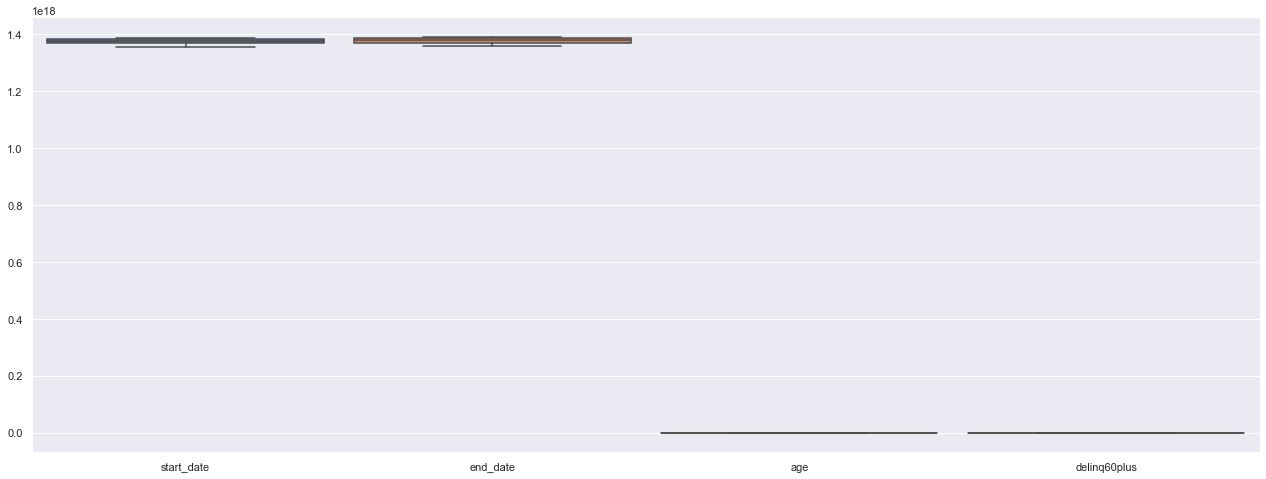

In [33]:
sns.set(rc={'figure.figsize':(22,8)})
sns.boxplot(data=cleaned_train, width=0.9)

<AxesSubplot:>

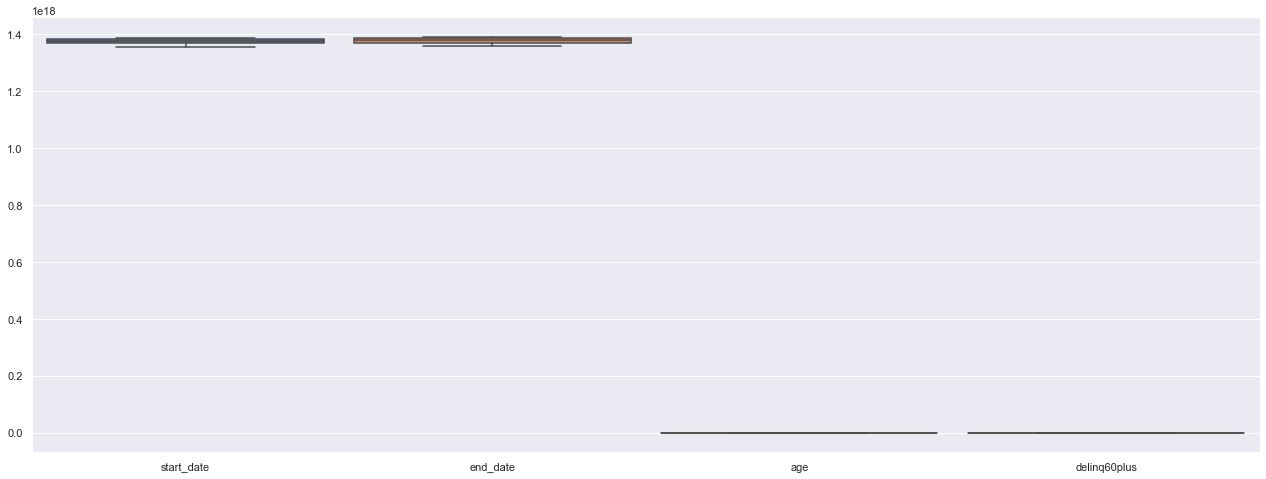

In [34]:
sns.set(rc={'figure.figsize':(22,8)})
sns.boxplot(data=cleaned_test, width=0.9)

## Поскольку в данном датасете преобладают категориальные признаки, сначала закодируем именно их

In [35]:
cleaned_train = pd.concat([cleaned_train,
                           pd.get_dummies(cleaned_train['gender'], prefix='gender'),
                           pd.get_dummies(cleaned_train['auto'], prefix='auto'),
                           pd.get_dummies(cleaned_train['housing'], prefix='housing'),
                           pd.get_dummies(cleaned_train['marstatus'], prefix='marstatus'),
                           pd.get_dummies(cleaned_train['regclient'], prefix='regclient'),
                           pd.get_dummies(cleaned_train['jobtype'], prefix='jobtype'),
                           pd.get_dummies(cleaned_train['region'], prefix='region'),
                           pd.get_dummies(cleaned_train['children'], prefix='children')], axis=1)

cleaned_train = cleaned_train.drop(['gender', 'auto', 'housing', 'marstatus', 'regclient',
              'jobtype', 'region', 'credits','children'], axis=1)

In [36]:
cleaned_test = pd.concat([cleaned_test,
                           pd.get_dummies(cleaned_test['gender'], prefix='gender'),
                           pd.get_dummies(cleaned_test['auto'], prefix='auto'),
                           pd.get_dummies(cleaned_test['housing'], prefix='housing'),
                           pd.get_dummies(cleaned_test['marstatus'], prefix='marstatus'),
                           pd.get_dummies(cleaned_test['regclient'], prefix='regclient'),
                           pd.get_dummies(cleaned_test['jobtype'], prefix='jobtype'),
                           pd.get_dummies(cleaned_test['region'], prefix='region'),
                           pd.get_dummies(cleaned_test['credits'], prefix='credits'),
                           pd.get_dummies(cleaned_test['children'], prefix='children')], axis=1)

cleaned_test = cleaned_test.drop(['gender', 'auto', 'housing', 'marstatus', 'regclient',
              'jobtype', 'region', 'credits','children'], axis=1)

In [37]:
y = 'delinq60plus'

x = cleaned_train.columns.to_list()
x.remove(y)



y_train = cleaned_train[y]
x_train = cleaned_train[x]

y_test = cleaned_test[y] 
x_test = cleaned_test[x] 

In [38]:
rfc = RandomForestClassifier(max_depth=10, n_estimators=500, random_state=0)
rfc.fit(x_train, y_train)
rfc.score(x_test, y_test)

0.7581408557364635

In [39]:
y_pred = rfc.predict_proba(x_test)[:,1]
roc_auc_score(y_test, y_pred)

0.8433180885467861